# Goal

Rerun the baseline calculation by viewport size as we discovered different default values in viewport size groups. Also analyze data collected after Dec. 21, 2023 to exclude the potential impact of [T352073](https://phabricator.wikimedia.org/T352073).


# Methodology

We defined the metrics as the ratio of the number of unique pageview sessions with non-default settings to the total number of unique pageview sessions that visited our site on a given day. We reviewed the minimum, maximum, average daily ratios, and the standard deviation for each individual feature as well as for the overall.


Our analysis uses data starting from Dec. 21, 2023 to Dec. 31, 2023, excluding NULL events in the baseline calculations. We operate on the assumption that the opt-out rate for NULL sessions is similar to that of other sessions.


# Summary of analysis
- Confirmed the high preview disable rate in `1000px-1200px` viewport group. This is because previews is not available for touch screen devices. Therefore, when calculating the preview disable rate, we will only include viewport sizes larger than 1200px. 

- The final version of baseline analysis
  - Full width enable rate: Include all viewport groups.
  - Preview disable rate: Only include viewport sizes larger than 1200px.
  - Pin rate: Only include viewport sizes larger than 1000px.
  - Media view disable rate: Include all viewport groups.
  - Overall non-default rate of the above features: Only include viewport sizes larger than 1200px.
  

Engineer QA Ticket: [T346106](https://phabricator.wikimedia.org/T346106)  
Data QA Ticket: [T346978](https://phabricator.wikimedia.org/T346978)  
Baseline Analysis Ticket: [T346979](https://phabricator.wikimedia.org/T346979)


__Baseline analysis on Jan. 05, 2024 and Jan. 31, 2024__   
__Jennifer Wang, Staff Data Scientist, Wikimedia Foundation__

In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [2]:
options(repr.plot.width = 15, repr.plot.height = 10)

In [72]:
query <- "
SELECT TO_DATE(dt) AS event_date, event.action , event.skin, event.isAnon, event.viewportSizeBucket, event.is_page_preview_on, event.is_full_width, event.is_media_viewer_enabled,event.is_pinned, 
count(Distinct event.token) AS count_session, count(1) AS events
FROM event.desktopwebuiactionstracking
WHERE year=2023 AND  month=12 
AND day BETWEEN 21 AND 31
AND event.is_page_preview_on IS NOT NULL
AND event.is_full_width  IS NOT NULL
AND event.is_media_viewer_enabled  IS NOT NULL
AND event.is_pinned  IS NOT NULL
AND event.action='init' AND event.skin='vector-2022'
AND NOT useragent.is_bot
GROUP BY  TO_DATE(dt), event.action, event.skin, event.isAnon, event.viewportSizeBucket, event.is_page_preview_on, event.is_full_width, event.is_media_viewer_enabled, event.is_pinned
ORDER BY  event.isAnon, event_date, event.viewportSizeBucket, event.is_page_preview_on, event.is_full_width, event.is_media_viewer_enabled, event.is_pinned
LIMIT 10000
"

In [73]:
df  <- wmfdata::query_hive(query )

Don't forget to authenticate with Kerberos using kinit



In [74]:
df$event_date <- as_date(df$event_date)

In [75]:
df$viewportsizebucket <- factor(df$viewportsizebucket, 
        levels=c("<320px","320px-719px","720px-999px","1000px-1199px","1200px-2000px",">2000px"))

# Full width enable rate (non default) 

In [77]:
df_full_width <- df %>%
 select(event_date, isanon, viewportsizebucket,is_full_width,count_session) %>%
 group_by(event_date, isanon, viewportsizebucket,is_full_width) %>%
 summarize(sum_sessions=sum(count_session),.groups='drop')

In [79]:
df_full_width_W  <-  df_full_width  %>%
     spread(key=is_full_width, value=sum_sessions, fill = 0) 



df_full_width_W  %>% 
    mutate(total_sessions = false+true,
          non_default_rate=round(true/total_sessions, 4)
        ) %>%
   arrange(isanon)

In [81]:
g <- df_full_width_W %>%
    mutate(total_sessions = false+true,
          non_default_rate=round(true/total_sessions, 4)
        ) %>% 
   filter(isanon=='false') %>%
   ggplot(aes(x = event_date, y= non_default_rate)) +
       geom_line( size = 1.5, color='red') +
        facet_wrap(~viewportsizebucket) +
        labs (
              y = "Non_default_rate" ,
             title = "Non_default_rate by viewport size bucket" ,
             caption = "User type: Logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
           # panel.grid.major = element_blank(), 
           # panel.grid.minor = element_blank(),
            #panel.background = element_blank(),
            axis.text.x = element_text(angle=90),
            plot.caption = element_text(hjust = 0, face= "italic"),
           # strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
g

In [82]:
g <- df_full_width_W %>%
    mutate(total_sessions = false+true,
          non_default_rate=round(true/total_sessions, 4)
        ) %>% 
   filter(isanon=='true') %>%
   ggplot(aes(x = event_date, y= non_default_rate)) +
       geom_line( size = 1.5, color='red') +
        facet_wrap(~viewportsizebucket) +
        labs (
              y = "Non default rate" ,
             title = "Non default rate by viewport size bucket" ,
             caption = "User type: anonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
           # panel.grid.major = element_blank(), 
           # panel.grid.minor = element_blank(),
            #panel.background = element_blank(),
            axis.text.x = element_text(angle=90),
            plot.caption = element_text(hjust = 0, face= "italic"),
           # strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
g

In [84]:
df_full_width_W <- df_full_width_W %>%
    mutate(total_sessions = false+true,
          non_default_rate=round(true/total_sessions, 4)
        )

In [86]:
df_full_width_W %>%
  group_by( isanon, viewportsizebucket)%>%
  summarize(min=min(non_default_rate), max=max(non_default_rate), avg=mean(non_default_rate), std=sd(non_default_rate), .groups='drop') 

isanon viewportsizebucket min    max    avg          std         
1  false  <320px             0.0360 0.0952 0.0551090909 0.0191351224
2  false  320px-719px        0.0433 0.0499 0.0469636364 0.0021527994
3  false  720px-999px        0.0315 0.0465 0.0402454545 0.0044681906
4  false  1000px-1199px      0.0512 0.0559 0.0531909091 0.0016397893
5  false  1200px-2000px      0.0515 0.0547 0.0527909091 0.0010173048
6  false  >2000px            0.0780 0.0881 0.0826818182 0.0030671870
7  true   <320px             0.0000 0.0049 0.0014545455 0.0014935619
8  true   320px-719px        0.0004 0.0008 0.0006181818 0.0001250454
9  true   720px-999px        0.0006 0.0012 0.0008181818 0.0001721522
10 true   1000px-1199px      0.0003 0.0004 0.0003636364 0.0000504525
11 true   1200px-2000px      0.0015 0.0020 0.0017181818 0.0001601136
12 true   >2000px            0.0021 0.0030 0.0025454545 0.0002659460

In [87]:
df_full_stats <- df_full_width_W %>%
    group_by(event_date, isanon) %>%
    summarize(sum_false=sum(false), sum_true=sum(true), .groups='drop') %>%
    mutate(
        total_sessions = sum_false+sum_true,
          non_default_rate=round(sum_true/total_sessions, 4)
        )

In [88]:
df_full_stats %>%
  group_by( isanon)%>%
  summarize(min=min(non_default_rate), max=max(non_default_rate), avg=mean(non_default_rate), std=sd(non_default_rate), .groups='drop') 

isanon min    max    avg         std         
1 false  0.0519 0.0546 0.053136364 0.0009563187
2 true   0.0013 0.0016 0.001481818 0.0001078720

### Baseline calculation
Full width enable rate:   
- Logged-in users: 5.3%
- Anonymous users: 0.15%

### Findings
The full width enable rate (non-default) is high in `>2000px` group.

# Preview disable rate (non default)

In [89]:
df_preview <- df %>%
 select(event_date, isanon, viewportsizebucket,is_page_preview_on,count_session) %>%
 group_by(event_date, isanon, viewportsizebucket,is_page_preview_on) %>%
 summarize(sum_sessions=sum(count_session),.groups='drop')

In [90]:
df_preview_W  <-  df_preview  %>%
     spread(key=is_page_preview_on, value=sum_sessions, fill = 0) 

In [91]:

df_preview_W <- df_preview_W  %>% 
    mutate(total_sessions = false+true,
    # preview is on by default
          non_default_rate=round(false/total_sessions, 4)
        ) %>%
   arrange(isanon)

In [100]:
g <- df_preview_W %>%
   filter(isanon=='false') %>%
   ggplot(aes(x = event_date, y= non_default_rate)) +
       geom_line( size = 1.5, color='red') +
        facet_wrap(~viewportsizebucket) +
        labs (
              y = "Non_default_rate" ,
             title = "Non_default_rate by viewport size bucket" ,
             caption = "User type: Logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
           # panel.grid.major = element_blank(), 
           # panel.grid.minor = element_blank(),
            #panel.background = element_blank(),
            axis.text.x = element_text(angle=90),
            plot.caption = element_text(hjust = 0, face= "italic"),
           # strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
g

In [101]:
g <- df_preview_W %>%
   filter(isanon=='true') %>%
   ggplot(aes(x = event_date, y= non_default_rate)) +
       geom_line( size = 1.5, color='red') +
        facet_wrap(~viewportsizebucket) +
        labs (
              y = "Non default rate" ,
             title = "Non default rate by viewport size bucket" ,
             caption = "User type: anonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
           # panel.grid.major = element_blank(), 
           # panel.grid.minor = element_blank(),
            #panel.background = element_blank(),
            axis.text.x = element_text(angle=90),
            plot.caption = element_text(hjust = 0, face= "italic"),
           # strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
g

In [93]:
df_preview_W %>% 
  group_by( isanon, viewportsizebucket)%>%
  summarize(min=min(non_default_rate), max=max(non_default_rate), avg=mean(non_default_rate), std=sd(non_default_rate), .groups='drop') 

isanon viewportsizebucket min    max    avg        std        
1  false  <320px             0.8190 0.9266 0.88995455 0.031533232
2  false  320px-719px        0.5760 0.6691 0.63121818 0.025612724
3  false  720px-999px        0.4843 0.6620 0.60955455 0.057114173
4  false  1000px-1199px      0.7507 0.7912 0.77573636 0.012023916
5  false  1200px-2000px      0.4364 0.4463 0.44181818 0.003040664
6  false  >2000px            0.4470 0.4864 0.47581818 0.010860922
7  true   <320px             0.3756 0.6640 0.56946364 0.071758613
8  true   320px-719px        0.1999 0.2793 0.23809091 0.028486995
9  true   720px-999px        0.1353 0.1997 0.16354545 0.020798864
10 true   1000px-1199px      0.5557 0.6767 0.61113636 0.039451116
11 true   1200px-2000px      0.0347 0.0386 0.03670000 0.001213260
12 true   >2000px            0.0283 0.0353 0.03056364 0.002294024

### Findings

The preview off rate (non-default) is high in `1000px-1199px` and `<320px` groups.

In [94]:
df_preview_stats <- df_preview_W  %>%
    group_by(event_date, isanon) %>%
    summarize(sum_false=sum(false), sum_true=sum(true), .groups='drop') %>%
    mutate(
        total_sessions = sum_false+sum_true,
          non_default_rate=round(sum_false/total_sessions, 4)
        )

In [95]:
df_preview_stats %>%
  group_by( isanon)%>%
  summarize(min=min(non_default_rate), max=max(non_default_rate), avg=mean(non_default_rate), std=sd(non_default_rate), .groups='drop') 

isanon min    max    avg       std        
1 false  0.4870 0.5128 0.5021455 0.008409799
2 true   0.1076 0.1608 0.1301545 0.017677860

In [112]:
df_preview_stats_1200px <- df_preview_W  %>%
    filter( viewportsizebucket=='1200px-2000px' | viewportsizebucket=='>2000px' ) %>% 
    group_by(event_date, isanon) %>%
    summarize(sum_false=sum(false), sum_true=sum(true), .groups='drop') %>%
    mutate(
        total_sessions = sum_false+sum_true,
          non_default_rate=round(sum_false/total_sessions, 4)
        )

In [113]:
df_preview_stats_1200px %>%
  group_by( isanon)%>%
  summarize(min=min(non_default_rate), max=max(non_default_rate), avg=mean(non_default_rate), std=sd(non_default_rate), .groups='drop') 

isanon min    max    avg        std        
1 false  0.4393 0.4478 0.44371818 0.002650214
2 true   0.0346 0.0383 0.03648182 0.001177131

### Baseline calculation 
(based on the data collected between Dec. 21, 2023 and Dec. 31, 2023)

Preview disable rate:   
- Logged-in users: 50.2%
- Anonymous users: 13.0%

Preview disable rate of sessions with viewport larger than 1200px:  
- Logged-in users: 44.37%
- Anonymous users: 3.65%


# Pin rate

In [30]:
df_pin <- df %>%
 select(event_date, isanon, viewportsizebucket,is_pinned,count_session) %>%
 group_by(event_date, isanon, viewportsizebucket,is_pinned) %>%
 summarize(sum_sessions=sum(count_session),.groups='drop')

In [31]:
df_pin_W  <-  df_pin  %>%
     spread(key=is_pinned, value=sum_sessions, fill = 0) 

In [32]:
df_pin_W  <- df_pin_W  %>% 
    mutate(total_sessions = false+true,
            is_pinned_rate=round(true/total_sessions, 4)
        ) %>%
   arrange(isanon)

In [34]:
df_pin_W %>% 
  group_by( isanon, viewportsizebucket)%>%
  summarize(min=min(is_pinned_rate), max=max(is_pinned_rate), avg=mean(is_pinned_rate), std=sd(is_pinned_rate), .groups='drop') 

isanon viewportsizebucket min    max    avg          std         
1  false  <320px             0.4104 0.5565 4.723545e-01 5.005660e-02
2  false  320px-719px        0.2223 0.2872 2.601818e-01 2.001648e-02
3  false  720px-999px        0.0239 0.0405 3.295455e-02 4.500525e-03
4  false  1000px-1199px      0.8428 0.8526 8.482273e-01 2.865690e-03
5  false  1200px-2000px      0.9272 0.9330 9.299455e-01 1.883276e-03
6  false  >2000px            0.9522 0.9614 9.569364e-01 2.725169e-03
7  true   <320px             0.0000 0.0023 7.727273e-04 8.355727e-04
8  true   320px-719px        0.0000 0.0001 5.454545e-05 5.222330e-05
9  true   720px-999px        0.0000 0.0000 0.000000e+00 0.000000e+00
10 true   1000px-1199px      0.0000 0.0001 9.090909e-05 3.015113e-05
11 true   1200px-2000px      0.0000 0.0000 0.000000e+00 0.000000e+00
12 true   >2000px            0.0000 0.0000 0.000000e+00 0.000000e+00

### Findings

For logged-in users,  
- We observe the pin rates are relatively lower in `<320px`, `320px-719px`, `720px-999px` compared with the large screen groups. Because when the screen size is smaller than 1000px, the menu is unpinned by default.  

- The pinned rate is high in `1000px-1199px`, `1200px-2000px` and `>2000px` groups because when the screen size is larger than 1000px, the menu is pinned by default.  

For anonymous users,
- We also observe the pin rates are low across the groups.

__Pin rate for viewport size larger than 1000px__ 

In [36]:
df_pin_stats <- df_pin_W %>%
    filter(viewportsizebucket=='1000px-1199px' | viewportsizebucket=='1200px-2000px' | viewportsizebucket=='>2000px' ) %>% 
    group_by(event_date, isanon) %>%
    summarize(sum_false=sum(false), sum_true=sum(true), .groups='drop') %>%
    mutate(
        total_sessions = sum_false+sum_true,
          pin_rate=round(sum_true/total_sessions, 4)
        )

In [37]:
df_pin_stats %>%
  group_by( isanon)%>%
  summarize(min=min(pin_rate), max=max(pin_rate), avg=mean(pin_rate), std=sd(pin_rate), .groups='drop') 

isanon min    max   avg       std        
1 false  0.9163 0.923 0.9194182 0.002323712
2 true   0.0000 0.000 0.0000000 0.000000000

### Baseline calculation

Overall pin rate of pageview sessions which have viewport size larger than 1000px:
- Loggined-in users, whose menus are pinned by default: 91.9% 
- Anonymous users, whose menus are unpinned by default: 0 %

# Media viewer disable rate (non-default)

In [39]:
df_media_viewer <- df %>%
 select(event_date, isanon, viewportsizebucket,is_media_viewer_enabled,count_session) %>%
 group_by(event_date, isanon, viewportsizebucket,is_media_viewer_enabled) %>%
 summarize(sum_sessions=sum(count_session),.groups='drop')

In [40]:
df_media_viewer_W  <-  df_media_viewer %>%
     spread(key=is_media_viewer_enabled, value=sum_sessions, fill = 0) 

In [41]:
df_media_viewer_W  <- df_media_viewer_W   %>% 
    mutate(total_sessions = false+true,
           # media viewer is enabled by default
            non_default_rate=round(false/total_sessions, 4)
        ) %>%
   arrange(isanon)

In [42]:
df_media_viewer_W  %>% 
  group_by( isanon, viewportsizebucket)%>%
  summarize(min=min(non_default_rate), max=max(non_default_rate), avg=mean(non_default_rate), std=sd(non_default_rate), .groups='drop') 

isanon viewportsizebucket min    max    avg          std         
1  false  <320px             0.0263 0.0750 0.0514000000 1.519882e-02
2  false  320px-719px        0.0354 0.0431 0.0398454545 2.598986e-03
3  false  720px-999px        0.0243 0.0338 0.0301454545 3.448873e-03
4  false  1000px-1199px      0.0461 0.0533 0.0488272727 1.942725e-03
5  false  1200px-2000px      0.0221 0.0252 0.0229636364 9.189915e-04
6  false  >2000px            0.0267 0.0311 0.0289181818 1.661215e-03
7  true   <320px             0.0000 0.0038 0.0017909091 1.376557e-03
8  true   320px-719px        0.0007 0.0010 0.0008636364 8.090398e-05
9  true   720px-999px        0.0008 0.0012 0.0009636364 1.286291e-04
10 true   1000px-1199px      0.0004 0.0005 0.0004909091 3.015113e-05
11 true   1200px-2000px      0.0003 0.0004 0.0003454545 5.222330e-05
12 true   >2000px            0.0002 0.0004 0.0002909091 5.393599e-05

In [43]:
df_media_viewer_stats <- df_media_viewer_W  %>%
    group_by(event_date, isanon) %>%
    summarize(sum_false=sum(false), sum_true=sum(true), .groups='drop') %>%
    mutate(
        total_sessions = sum_false+sum_true,
               # media viewer is enabled by default
        non_default_rate=round(sum_false/total_sessions, 4)
        )

In [44]:
df_media_viewer_stats  %>%
  group_by( isanon)%>%
  summarize(min=min(non_default_rate), max=max(non_default_rate), avg=mean(non_default_rate), std=sd(non_default_rate), .groups='drop') 

isanon min    max    avg        std         
1 false  0.0261 0.0294 0.02740909 0.0009863615
2 true   0.0004 0.0004 0.00040000 0.0000000000

### Baseline calculation
Overall disable rate of media views (non-defalut):
- Loggined-in users: 2.74% 
- Anonymous users: 0.04%

# Overall non-default rate

## Overall non-default rate (only viewport >= 1200px)

In [102]:
df_overall_summary_1200px <- df %>%
  filter( viewportsizebucket=='1200px-2000px' | viewportsizebucket=='>2000px' ) %>% 
  mutate(
       settings = case_when(

         # For loggin users: main menu & tools is pinned by default
           isanon=='false' & is_pinned=='true' & is_page_preview_on=='true'  & is_full_width=='false' & is_media_viewer_enabled=='true' ~ 'default',
          #For anonymous users : main menu & tools unpinned by default
            isanon=='true' & is_pinned=='false' & is_page_preview_on=='true'  & is_full_width=='false' & is_media_viewer_enabled=='true' ~ 'default',
           TRUE ~ 'non_default')
      ) %>%
  group_by(event_date, action, skin, isanon,viewportsizebucket, settings ) %>%
  summarize(sum_sessions=sum(count_session),.groups='drop')

In [103]:
head(df_overall_summary_1200px )

event_date action skin        isanon viewportsizebucket settings   
1 2023-12-21 init   vector-2022 false  1200px-2000px      default    
2 2023-12-21 init   vector-2022 false  1200px-2000px      non_default
3 2023-12-21 init   vector-2022 false  >2000px            default    
4 2023-12-21 init   vector-2022 false  >2000px            non_default
5 2023-12-21 init   vector-2022 true   1200px-2000px      default    
6 2023-12-21 init   vector-2022 true   1200px-2000px      non_default
  sum_sessions
1   59420     
2   58049     
3    3329     
4    3949     
5 3539274     
6  143645

In [104]:
df_overall_summary_1200px_W  <-  df_overall_summary_1200px %>%
     spread(key=settings, value=sum_sessions, fill=0) 

In [105]:
df_overall_summary_1200px_W  <-  df_overall_summary_1200px %>%
     spread(key=settings, value=sum_sessions, fill=0) 

In [106]:
df_overall_summary_1200px_W <- df_overall_summary_1200px_W  %>% 
    mutate(total_sessions = default+non_default,
          non_default_rate=round(non_default/total_sessions, 4)
        ) %>%
   arrange(isanon)

In [107]:
df_overall_1200px_stats <- df_overall_summary_1200px_W   %>%
    group_by(event_date, isanon) %>%
    summarize(sum_non_default=sum(non_default), sum_default=sum(default), .groups='drop') %>%
    mutate(
        total_sessions = sum_non_default+sum_default,
        non_default_rate=round(sum_non_default/total_sessions, 4)
        )

In [109]:
df_overall_1200px_stats

event_date isanon sum_non_default sum_default total_sessions
1  2023-12-21 false   61998            62749      124747       
2  2023-12-21 true   148921          3674351     3823272       
3  2023-12-22 false   58661            58327      116988       
4  2023-12-22 true   127385          3129286     3256671       
5  2023-12-23 false   53375            52902      106277       
6  2023-12-23 true    95401          2311135     2406536       
7  2023-12-24 false   51236            50119      101355       
8  2023-12-24 true    92657          2198797     2291454       
9  2023-12-25 false   50060            49275       99335       
10 2023-12-25 true   103477          2566863     2670340       
11 2023-12-26 false   56469            56214      112683       
12 2023-12-26 true   117964          3119631     3237595       
13 2023-12-27 false   59745            59982      119727       
14 2023-12-27 true   127107          3368136     3495243       
15 2023-12-28 false   60317            59712      120029       
16 2023-12-28 true   126183          3257216     3383399       
17 2023-12-29 false   59071            58045      117116       
18 2023-12-29 true   115888          2903501     3019389       
19 2023-12-30 false   56742            55197      111939       
20 2023-12-30 true    98013          2437392     2535405       
21 2023-12-31 false   53536            51802      105338       
22 2023-12-31 true    92465          2269516     2361981       
   non_default_rate
1  0.4970          
2  0.0390          
3  0.5014          
4  0.0391          
5  0.5022          
6  0.0396          
7  0.5055          
8  0.0404          
9  0.5040          
10 0.0388          
11 0.5011          
12 0.0364          
13 0.4990          
14 0.0364          
15 0.5025          
16 0.0373          
17 0.5044          
18 0.0384          
19 0.5069          
20 0.0387          
21 0.5082          
22 0.0391

In [108]:
df_overall_1200px_stats  %>%
  group_by( isanon)%>%
  summarize(min=min(non_default_rate), max=max(non_default_rate), avg=mean(non_default_rate), std=sd(non_default_rate), .groups='drop') 

isanon min    max    avg        std        
1 false  0.4970 0.5082 0.50292727 0.003323580
2 true   0.0364 0.0404 0.03847273 0.001272078

### Baseline calculation

(based on the data collected between Dec. 21, 2023 and Dec. 31, 2023)

Non default rate of sessions with viewport larger than 1200px:   
- Logged-in users: 50.29%
- Anonymous users: 3.85%


# Deep dive for curiosity

## Distribution of the sessions by viewport size bucket

In [64]:
df_session <- df %>%
  group_by(event_date, isanon,viewportsizebucket) %>%
  summarize(sum_session=sum(count_session), .groups='drop') 

df_session %>%
  group_by(event_date, isanon) %>%
  mutate(
      ptg=round(sum_session/sum(sum_session),4)
      ) 

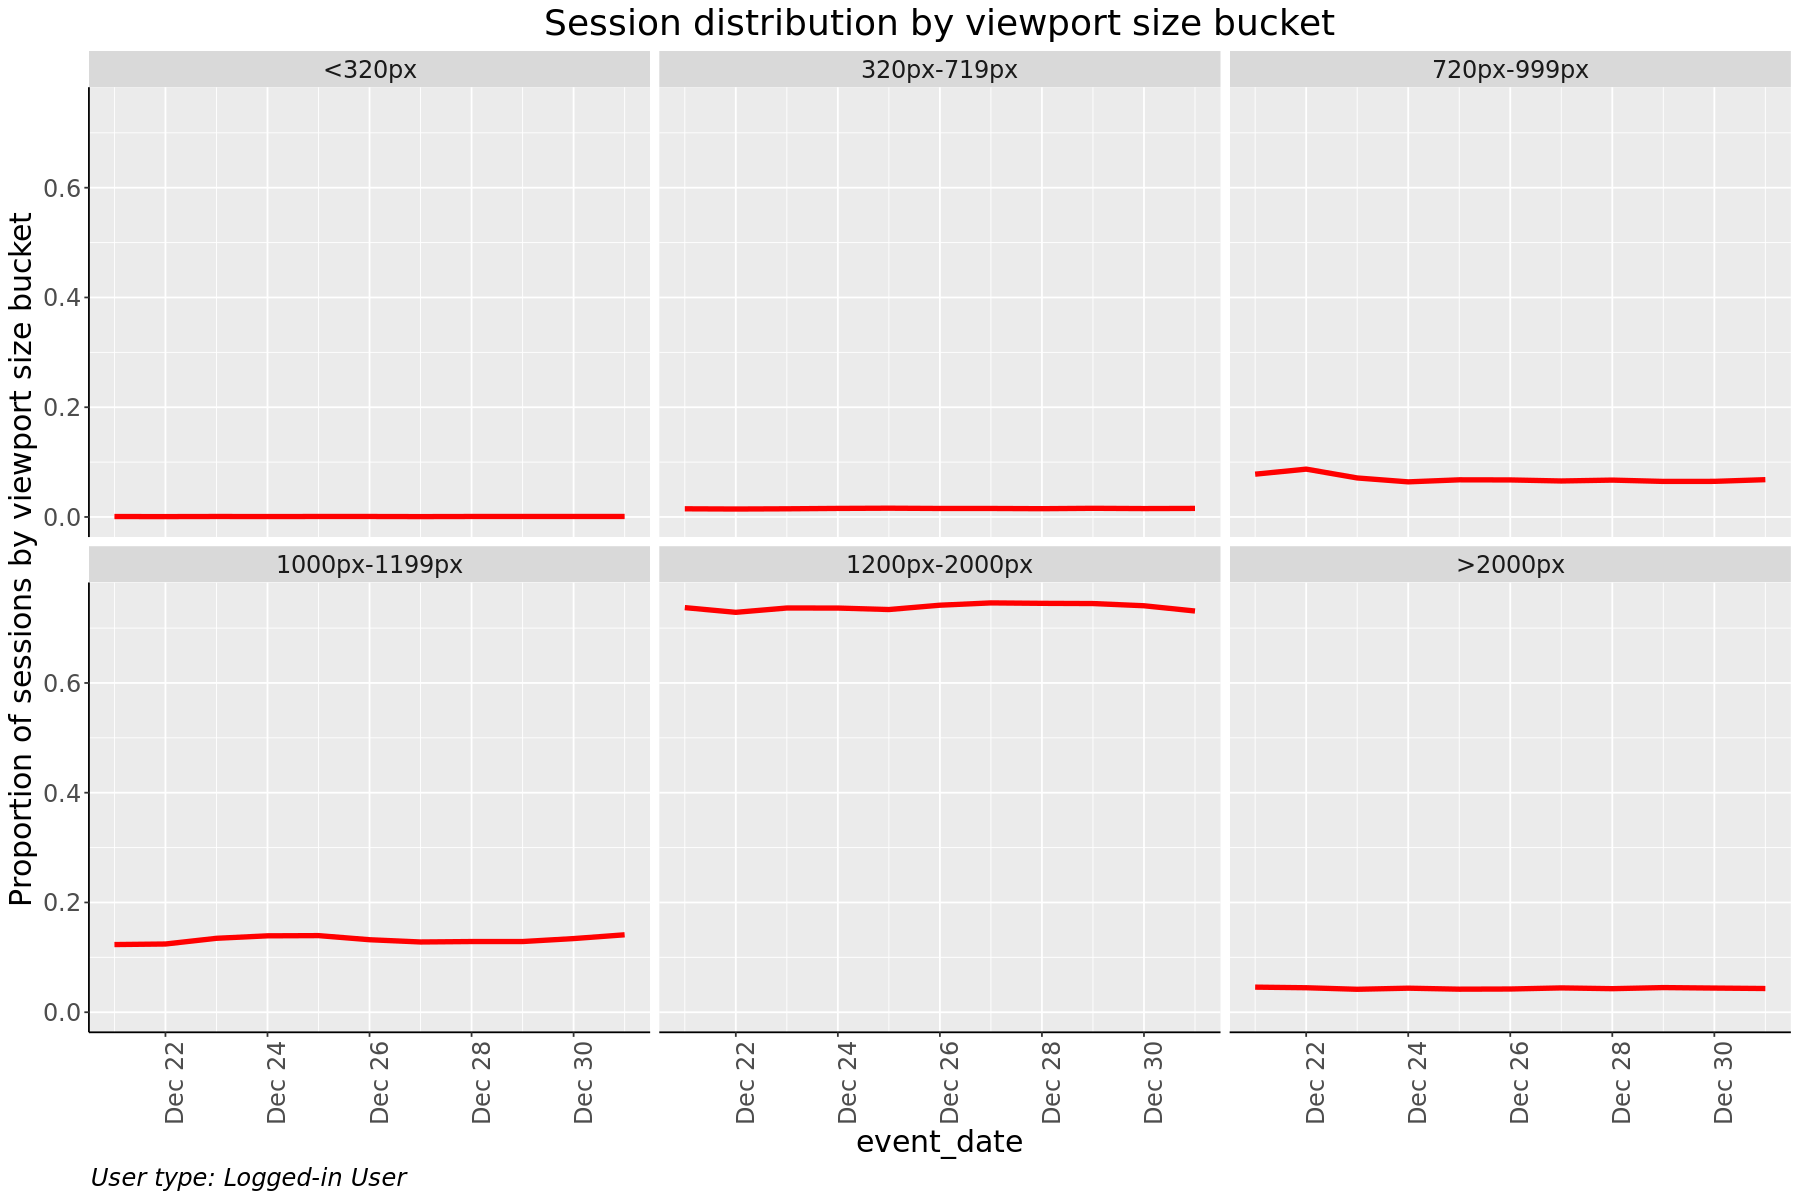

In [67]:
g <- df_session %>%
  group_by(event_date, isanon) %>%
  mutate(
      ptg=round(sum_session/sum(sum_session),4)
      )  %>%
   filter(isanon=='false') %>%
   ggplot(aes(x = event_date, y= ptg)) +
       geom_line( size = 1.5, color='red') +
        facet_wrap(~viewportsizebucket) +
        labs (
              y = "Proportion of sessions by viewport size bucket" ,
             title = "Session distribution by viewport size bucket" ,
             caption = "User type: Logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
           # panel.grid.major = element_blank(), 
           # panel.grid.minor = element_blank(),
            #panel.background = element_blank(),
            axis.text.x = element_text(angle=90),
            plot.caption = element_text(hjust = 0, face= "italic"),
           # strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
g

### Findings

The proportion of sessions by viewport size bucket remains stable during our observation window. We can simply calculate this proportion by using the overall rate.



In [69]:
df_session %>%
  group_by( isanon, viewportsizebucket) %>%
  summarize(total_session=sum(sum_session), .groups='drop')

isanon viewportsizebucket total_session
1  false  <320px                 1357     
2  false  320px-719px           24177     
3  false  720px-999px          110316     
4  false  1000px-1199px        208262     
5  false  1200px-2000px       1166607     
6  false  >2000px               68927     
7  true   <320px                11149     
8  true   320px-719px          504398     
9  true   720px-999px         1866725     
10 true   1000px-1199px       5906274     
11 true   1200px-2000px      31277646     
12 true   >2000px             1203639

In [70]:
df_session %>%
  group_by( isanon, viewportsizebucket) %>%
  summarize(total_session=sum(sum_session), .groups='drop') %>%
  group_by( isanon) %>%
  mutate(
      ptg=round(total_session/sum(total_session),4)
      )

isanon viewportsizebucket total_session ptg   
1  false  <320px                 1357      0.0009
2  false  320px-719px           24177      0.0153
3  false  720px-999px          110316      0.0698
4  false  1000px-1199px        208262      0.1318
5  false  1200px-2000px       1166607      0.7385
6  false  >2000px               68927      0.0436
7  true   <320px                11149      0.0003
8  true   320px-719px          504398      0.0124
9  true   720px-999px         1866725      0.0458
10 true   1000px-1199px       5906274      0.1449
11 true   1200px-2000px      31277646      0.7672
12 true   >2000px             1203639      0.0295

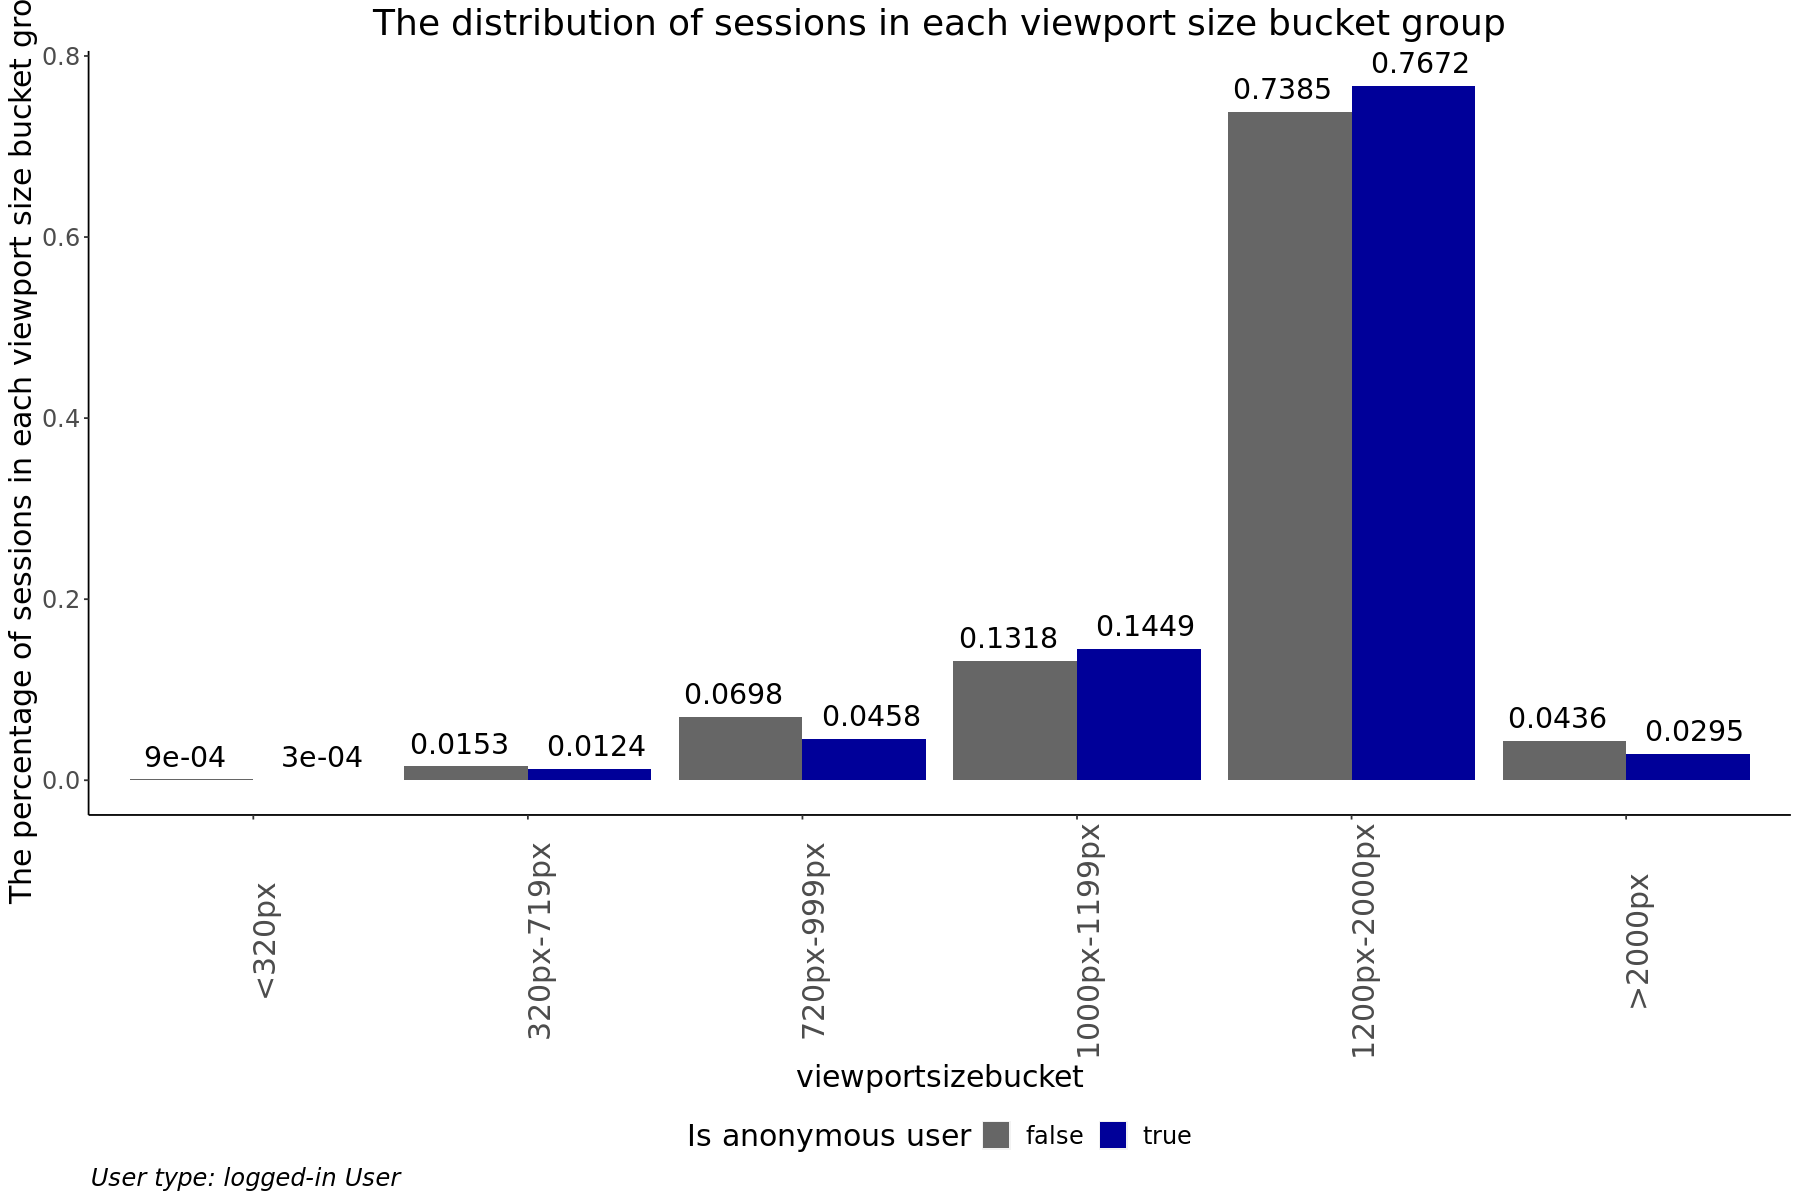

In [71]:
barchart_sessions_viewsizebucket_overall <- df_session %>%
  group_by( isanon, viewportsizebucket) %>%
  summarize(total_session=sum(sum_session), .groups='drop') %>%
  group_by( isanon) %>%
  mutate(
      ptg=round(total_session/sum(total_session),4)
      ) %>% 
  ggplot(aes(x = viewportsizebucket, y= ptg, fill=isanon)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(ptg)), color = "black", position = position_dodge(width = 1), 
                vjust = -0.6, hjust = 0.5, size = 6) +
        labs (
              y = "The percentage of sessions in each viewport size bucket group" ,
             title = "The distribution of sessions in each viewport size bucket group" ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "Is anonymous user")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_viewsizebucket_overall

### Findings
- Generally, majority of users use devices with 1200px-2000px
  - 73.85% of loggined-in user sessions
  - 76.72% of anonymous user sessions
- Percentage of sessions with a viewport larger than 1000px
   - 91.4% of loggined-in user sessions
   - 94.2% of anonymous user sessions


